In [1]:
!nvidia-smi

Fri Nov 24 12:19:35 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           On  | 00000000:06:00.0 Off |                    0 |
| N/A   32C    P0              41W / 300W |      3MiB / 16384MiB |      0%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_VISIBLE_DEVICES=0
env: CUDA_LAUNCH_BLOCKING=1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("./..")

In [5]:
# from src.numerical_methods import *

In [6]:
import json

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.models.resnet import resnet50


from architectures import get_architecture
from datasets_utils import get_dataset, DATASETS, get_num_classes, get_normalize_layer

In [7]:
from src.certification_utils import *
from src.smoothing_and_attacks import *
from src.utils import *
from src.numerical_methods import norm_to_exp, norm_to_ray, norm_to_exp_1d, norm_to_exp_1d, construct_gamma

In [8]:
rng = jax.random.PRNGKey(33)
rng, key = jax.random.split(rng)

In [9]:
ns = 10_000
normal_samples = jax.random.normal(key, [100_000])

In [10]:
# def norm_to_exp(c, lam):
#     print(c.shape)
#     idx = np.random.randint(0, len(normal_samples), (c.shape[0], 4))
#     q = normal_samples[idx]
    
#     return jax.numpy.abs(q[:, 0] * q[:, 1] - q[:, 2] * q[:, 3]) / lam
    
    
# def norm_to_ray(c, sigma):
#     idx = np.random.randint(0, len(normal_samples), (c.shape[0], 2))
#     c01 = normal_samples[idx] * sigma 
# #     c = c * sigma
#     return jnp.sqrt(c01[:, 0] ** 2 + c01[:, 1] ** 2)

In [11]:
# def norm_to_exp_1d(c, lam):

#     idx = np.random.randint(0, len(normal_samples), 4)
#     q = normal_samples[idx]
    
#     return jax.numpy.abs(q[0] * q[1] - q[2] * q[3]) / lam
    
    
# def norm_to_exp_1d(c, sigma):
#     idx = np.random.randint(0, len(normal_samples), 2)
#     c01 = normal_samples[idx] * sigma 
#     c = c * sigma
#     return jnp.sqrt(c ** 2 + c01[1] ** 2)

In [12]:
# def norm_to_exp_torch(s, lam):
#     norm1 = torch.randn(s)
#     norm2 = torch.randn(s)
#     norm3 = torch.randn(s)
#     norm4 = torch.randn(s)
#     return torch.abs(norm1 * norm2 - norm3 * norm4) / lam
    

In [13]:
sigma_b = None
sigma_c = None
sigma_tr = None
sigma_gamma = None
sigma_blur = None

xi_tss = scipy.stats.norm.ppf

# def gamma(x, b, c, tr_type:str):

    
#     if tr_type == 'ct': 
        
#         c0 = c[0] / DEFAULT_SIGMA *sigma_c
#         c1 = c[1] / DEFAULT_SIGMA *sigma_tr
#         c2 = c[2] / DEFAULT_SIGMA *sigma_tr
        
        
#         b0 = b[0]*norm_to_lognorm(c0)
#         b1 = b[1] + c1
#         b2 = b[2] + c2

#         return jnp.array([b0,b1,b2])
    
#     if tr_type == 'cbt': #
#         c0 = norm_to_lognorm(c[0]*sigma_c)
#         c1 = c[1]*sigma_b
#         c2 = c[2]*sigma_tr
#         c3 = c[3]*sigma_tr



#         b0 = c0*b[0]
#         b1 = b[1]*c0 +c1
#         b2 = b[2] +c2
#         b3 = b[3] + c3

#         return jnp.array([b0,b1, b2, b3])
    
#     if tr_type == 'tbbc': #translation -  -Blur- Brightness - Contrast
#         # Norm(0, 1) -> Laplace(1/sigma_blur) -> Exp(sigma_blur)
#         c0 = c[0] / DEFAULT_SIGMA * sigma_tr
#         c1 = c[1] / DEFAULT_SIGMA * sigma_tr
#         c2 = c[2] / DEFAULT_SIGMA #* sigma_blur
#         c3 = c[3] / DEFAULT_SIGMA * sigma_b
#         c4 = c[5] / DEFAULT_SIGMA * sigma_c

#         x2 = jax.random.normal(key)
#         x3 = jax.random.normal(key)
#         x4 = jax.random.normal(key)
#         c2 = norm_to_exp_1d(c2, sigma_blur)
#         b0 = b[0] + c0
#         b1 = b[1] + c1
# #         b2 = b[2] + norm_to_exp(c2) * sigma_blur
#         b2 = b[2] + c2
#         b3 = b[3] + c3 / b[4]
#         b4 = norm_to_lognorm(c4)*b[4]

#         return jnp.array([b0,b1,b2,b3,b4])

#     if tr_type == 'tbbc_ray': #translation -  -Blur- Brightness - Contrast

#         c0 = c[0] / DEFAULT_SIGMA * sigma_tr
#         c1 = c[1] / DEFAULT_SIGMA * sigma_tr
#         c2 = c[2] / DEFAULT_SIGMA
#         c3 = c[3] / DEFAULT_SIGMA * sigma_b
#         c4 = c[5] / DEFAULT_SIGMA * sigma_c



#         c2 = norm_to_ray_1d(c2, sigma_blur)

#         b0 = b[0] + c0
#         b1 = b[1] + c1
#         b2 = b[2] + c2
#         b3 = b[3] + c3 / b[4]
#         b4 = norm_to_lognorm(c4)*b[4]

#         return jnp.array([b0,b1,b2,b3,b4])


In [14]:
device = torch.device("cuda")

n0 = 200
maxn = 1000
adaptive=False # whether to stop certification procedure earlier
alpha = 1e-3 # confidence

In [15]:
def make_our_dataset_v2(data, idxes):
    images = []
    labels = []
    k = 0
    for i in tqdm(range(len(idxes))):
        image, label = data[idxes[i]]
        images.append(image.numpy())
        
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    dataset = CustomAudioDataset(images, labels)
    return dataset

test_dataset = get_dataset('imagenet', 'test')
pin_memory = False  # ('imagenet' == "imagenet")
bs = 64

NUM_IMAGES_FOR_TEST = 500
idxes = np.random.choice(len(test_dataset), NUM_IMAGES_FOR_TEST , replace=False)

print(idxes[:10])


/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


[ 8343  2030 20672 35753 48632  6994  9470 23701 47269  8945]


In [16]:
ourdataset100 = make_our_dataset_v2(test_dataset, idxes)

dataloader100 = DataLoader(ourdataset100, shuffle=False, batch_size=1,
                         num_workers=6, pin_memory=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 45.44it/s]


In [17]:
NUM_IMAGES_FOR_TEST = 500
cifar10_ds = get_dataset('cifar10', 'test')
idxes2 = np.random.choice(len(cifar10_ds), NUM_IMAGES_FOR_TEST , replace=False)

our_cifar10_500 = make_our_dataset_v2(cifar10_ds, idxes2)
dataloader_cifar10 = DataLoader(our_cifar10_500, shuffle=False, batch_size=1,
                         num_workers=6, pin_memory=False)

Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 6761.23it/s]


In [18]:
cifar100_ds = get_dataset('cifar100', 'test')
idxes3 = np.random.choice(len(cifar10_ds), NUM_IMAGES_FOR_TEST , replace=False)

our_cifar100_500 = make_our_dataset_v2(cifar100_ds, idxes3)
dataloader_cifar100 = DataLoader(our_cifar100_500, shuffle=False, batch_size=1,
                         num_workers=6, pin_memory=False)

Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 6939.36it/s]


In [19]:
def construct_bounds(ns, b_zero, x0, d, betas_list, type_of_transform, sigmas=[1, 1, 1, 1, 1]):
    shape = [b.shape[0] for b in betas_list]
    print("I'm here")
    shape = tuple(shape)
    betas = jnp.asarray(list(map(jnp.array, itertools.product(*betas_list))))
    sigma_b, sigma_c, sigma_tr, sigma_gamma, sigma_blur = sigmas
    gamma = construct_gamma(sigma_b=sigma_b, sigma_c=sigma_c, sigma_tr=sigma_tr, sigma_gamma=sigma_gamma, sigma_blur=sigma_blur)
    bounds, p, g = compute_normed_bounds(compute_bound, x0, gamma, b_zero, betas, key, ns, d, type_of_transform)
    x, xi = pxi_to_xi(p)
    for b in bounds[:1000]:
        plt.plot(b)
    plt.show()

    plt.plot(g)
    plt.show()

    plt.plot(p)
    plt.show()
    z = csaps(betas_list, g.reshape(shape))
    
    hg = []

    for beta in tqdm(betas):
        hat_g = g_to_hat_g(z, beta, b_zero)
        hg.append(hat_g)

    hat_g = jnp.asarray(hg)

    hatg_int = csaps(betas_list, hat_g.reshape(shape)) #
    return xi, hatg_int

# Brightness

In [20]:
sigma_b = 0.3

In [21]:
phi = construct_phi("b", device, sigma_b=sigma_b)

In [22]:
phi(torch.tensor([1]).to(device))

tensor([[[[1.4815]]]], device='cuda:0')

I'm here


  0%|                                                                                                                                                  | 0/41 [00:00<?, ?it/s]

b
b
b
b


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 27.38it/s]


(41, 20000)
(41,)
(20000,)


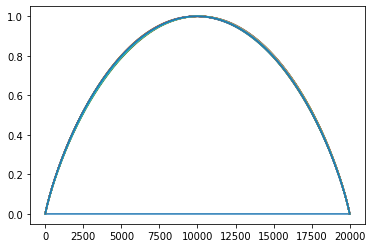

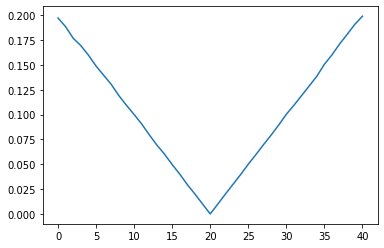

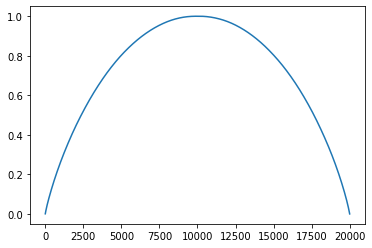

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 192.82it/s]


In [23]:
ns = 20000
b_zero = jnp.array([0.])
x0 = jnp.array([1.1]) # Whatever
d = 1

betas1 = jnp.linspace(-0.5, 0.5, 41)
betas_list = [betas1]
type_of_transform = 'b'

Phi = construct_phi(type_of_transform, device, sigma_b=sigma_b, sigma_c=sigma_c)
attack = attack_b_torch
res_bc = construct_bounds(ns, b_zero, x0, d, betas_list, type_of_transform)
xi, hatg_int = res_bc

In [24]:
hatg_int([*b_zero]).item()

0.0033275563436123623

## CIFAR-10

In [25]:
# k = 0
# image = ourdataset100[k][0]
# label = ourdataset100[k][1]
# imshow(image)

In [26]:
model = get_architecture(arch="cifar_resnet110", dataset="cifar10", device=device)

checkpoint = torch.load('../tss_weights/cifar10/resnet110/brightness-contrast/0.3_0.3/consistency/checkpoint.pth.tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [27]:
iscor_bc = Accuracy(model, loader=dataloader_cifar10, device=device) # Accuracy of non-smoothed model on original images

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.74it/s]

0.862


In [28]:
betas_attack_list = [np.linspace(-0.4, 0.4, 21)]
betas_attack = np.asarray(list(map(np.array, itertools.product(*betas_attack_list))))


In [30]:
pas_b = pa_isOk_collector(model, loader=dataloader_cifar10, Phi=Phi, device=device,
                           n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive,
                             num_classes=10)
paCP, isOkCP = pas_b # Clopper - Pearson

print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:51<00:00,  4.48it/s]

Ordinary accuracy of Smoothed Classiifer 0.86


In [31]:
hlist = np.linspace(0.7, 1.0, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2612.03it/s]

Cert Acc b our 0.856 h_min is 0.7


In [36]:
hlist = np.linspace(0.85, 1.0, 300)
sb_tss = safe_beta_tss(type_of_transform, sigma_b=sigma_b)
hmin = CertAccCheckerTSS(betas=betas_attack, hlist=hlist, xi=xi_tss, safe_beta_tss=sb_tss)
cert_acc_within_betas_bounds = ((paCP>hmin)*isOkCP).mean()
print(f'Cert Acc {type_of_transform} TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 901.05it/s]

Cert Acc b TSS 0.85 h_min is 0.9091973244147157


## CIFAR-100

In [37]:
model = get_architecture(arch="cifar100_resnet110", dataset="cifar100", device=device)

checkpoint = torch.load('../new_results/cifar100_resnet110_cifar100_cb_cifar100_cb_checkpoint.pth.tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [38]:
iscor_bc = Accuracy(model, loader=dataloader_cifar100, device=device) # Accuracy of non-smoothed model on original images

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.44it/s]

0.486


In [39]:
pas_b = pa_isOk_collector(model, loader=dataloader_cifar100, Phi=Phi, device=device,
                           n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive,
                             num_classes=100)
paCP, isOkCP = pas_b # Clopper - Pearson

print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:52<00:00,  4.45it/s]

Ordinary accuracy of Smoothed Classiifer 0.482


In [40]:
hlist = np.linspace(0.7, .8, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2409.79it/s]

Cert Acc b our 0.456 h_min is 0.7


In [41]:
hlist = np.linspace(0.9, 1.0, 300)
sb_tss = safe_beta_tss(type_of_transform, sigma_b=sigma_b)
hmin = CertAccCheckerTSS(betas=betas_attack, hlist=hlist, xi=xi_tss, safe_beta_tss=sb_tss)
cert_acc_within_betas_bounds = ((paCP>hmin)*isOkCP).mean()
print(f'Cert Acc {type_of_transform} TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1036.01it/s]

Cert Acc b TSS 0.438 h_min is 0.9090301003344482


## ImageNet

In [42]:
model = get_architecture(arch="resnet50", dataset="imagenet", device=device)

checkpoint = torch.load('../tss_weights/imagenet/resnet50/brightness-contrast/0.4_0.4/consistency/checkpoint.pth.tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [43]:
iscor_bc = Accuracy(model, loader=dataloader100, device=device) # Accuracy of non-smoothed model on original images

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 64.13it/s]

0.76


In [ ]:
pas_b = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device,
                           n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive,
                             num_classes=1000)
paCP, isOkCP = pas_b # Clopper - Pearson

print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

In [ ]:
betas_attack_list = [np.linspace(-0.4, 0.4, 21)]
betas_attack = np.asarray(list(map(np.array, itertools.product(*betas_attack_list))))

In [ ]:
hlist = np.linspace(0.7, .8, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

In [ ]:
hlist = np.linspace(0.9, 1.0, 300)
sb_tss = safe_beta_tss(type_of_transform, sigma_b=sigma_b)
hmin = CertAccCheckerTSS(betas=betas_attack, hlist=hlist, xi=xi_tss, safe_beta_tss=sb_tss)
cert_acc_within_betas_bounds = ((paCP>hmin)*isOkCP).mean()
print(f'Cert Acc {type_of_transform} TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

# Contrast

I'm here


  0%|                                                                                                                                                  | 0/41 [00:00<?, ?it/s]

c
c
c
c


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 20.61it/s]


(41, 20000)
(41,)
(20000,)


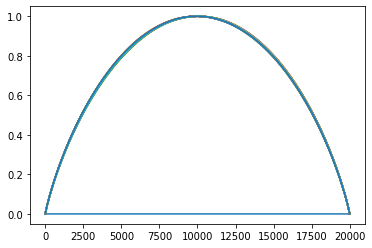

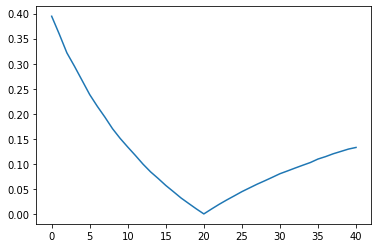

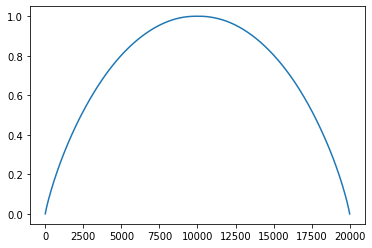

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 214.79it/s]


In [46]:
sigma_c = 0.3
sigmas = [None, sigma_c, None, None, None]

ns = 20000
b_zero = jnp.array([1.0])
x0 = jnp.array([1.1]) # Whatever
d = 1

betas1 = jnp.linspace(0.5, 1.5, 41)
betas_list = [betas1]
type_of_transform = 'c'

Phi = construct_phi(type_of_transform, device, sigma_c=sigma_c)
attack = attack_c_torch
res_c = construct_bounds(ns, b_zero, x0, d, betas_list, type_of_transform)
xi, hatg_int = res_c

In [47]:
betas_attack_list = [np.linspace(0.7, 1.3, 21)]
betas_attack = np.asarray(list(map(np.array, itertools.product(*betas_attack_list))))


In [48]:
def safe_beta_MP_gamma(xi, h, bs):
    gam = bs[0]
    
    r_mp_g_r = lambda h: np.sqrt( - np.log(1-h)/np.log(2))
    r_mp_g_l = lambda h: np.sqrt( - np.log(h)/np.log(2))
#     if gam >= 1.0:
        
#         cond = r_mp_g_r(h)
#         print(cond)
#         return gam < cond
#     else:
#         cond = r_mp_g_l(h)
#         return gam > cond

    cond_l = r_mp_g_l(h)
    cond_r = r_mp_g_r(h)
    return cond_l < gam and gam < cond_r
    
    

## CIFAR-10

In [49]:
model = get_architecture(arch="cifar_resnet110", dataset="cifar10", device=device)

checkpoint = torch.load('../tss_weights/cifar10/resnet110/brightness-contrast/0.3_0.3/consistency/checkpoint.pth.tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [50]:
iscor_bc = Accuracy(model, loader=dataloader_cifar10, device=device) # Accuracy of non-smoothed model on original images

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 41.89it/s]

0.862


In [51]:
pas_b = pa_isOk_collector(model, loader=dataloader_cifar10, Phi=Phi, device=device,
                           n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive,
                             num_classes=10)
paCP, isOkCP = pas_b # Clopper - Pearson
print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:51<00:00,  4.50it/s]

Ordinary accuracy of Smoothed Classiifer 0.86


In [52]:
hlist = np.linspace(0.5, 1.0, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1286.01it/s]

Cert Acc c our 0.858 h_min is 0.5752508361204014


In [53]:
hlist = np.linspace(0.5, 1, 300)
hmin = CertAccCheckerTSS(betas=betas_attack, hlist=hlist, xi=None, safe_beta_tss=safe_beta_MP_gamma)
cert_acc_within_betas_bounds = ((paCP>hmin)*isOkCP).mean()
print('Cert Acc contrast MP', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 20991.51it/s]

Cert Acc contrast MP 0.852 h_min is 0.7123745819397993


## CIFAR-100

In [43]:
model = get_architecture(arch="cifar100_resnet110", dataset="cifar100", device=device)

checkpoint = torch.load('../new_results/cifar100_resnet110_cifar100_cb_cifar100_cb_checkpoint.pth.tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [44]:
iscor_bc = Accuracy(model, loader=dataloader_cifar100, device=device) # Accuracy of non-smoothed model on original images

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.19it/s]

0.478


In [45]:
pas_b = pa_isOk_collector(model, loader=dataloader_cifar100, Phi=Phi, device=device,
                           n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive,
                             num_classes=100)
paCP, isOkCP = pas_b # Clopper - Pearson

print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:53<00:00,  4.41it/s]

Ordinary accuracy of Smoothed Classiifer 0.472


In [46]:
hlist = np.linspace(0.5, 1.0, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1832.83it/s]

Cert Acc c our 0.452 h_min is 0.5752508361204014


In [47]:
hlist = np.linspace(0.5, 1, 300)
hmin = CertAccCheckerTSS(betas=betas_attack, hlist=hlist, xi=None, safe_beta_tss=safe_beta_MP_gamma)
cert_acc_within_betas_bounds = ((paCP>hmin)*isOkCP).mean()
print('Cert Acc contrast MP', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 20966.53it/s]

Cert Acc contrast MP 0.428 h_min is 0.7123745819397993


## Imagenet

In [48]:
model = get_architecture(arch="resnet50", dataset="imagenet", device=device)

checkpoint = torch.load('../tss_weights/imagenet/resnet50/brightness-contrast/0.4_0.4/consistency/checkpoint.pth.tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [49]:
iscor_bc = Accuracy(model, loader=dataloader100, device=device) # Accuracy of non-smoothed model on original images

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 63.62it/s]

0.706


In [50]:
pas_b = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device,
                           n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive,
                             num_classes=1000)
paCP, isOkCP = pas_b # Clopper - Pearson

print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [08:38<00:00,  1.04s/it]

Ordinary accuracy of Smoothed Classiifer 0.708


In [51]:
hlist = np.linspace(0.5, 1.0, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2915.80it/s]

Cert Acc c our 0.704 h_min is 0.5752508361204014


In [52]:
hlist = np.linspace(0.5, 1, 300)
hmin = CertAccCheckerTSS(betas=betas_attack, hlist=hlist, xi=None, safe_beta_tss=safe_beta_MP_gamma)
cert_acc_within_betas_bounds = ((paCP>hmin)*isOkCP).mean()
print('Cert Acc contrast MP', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 21097.10it/s]

Cert Acc contrast MP 0.7 h_min is 0.7123745819397993


# Blur

In [97]:
def attack_blur_cv2(x, b):
    r = b 
    input = x[0].cpu().numpy()
    r = r.item()
    out = cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), np.sqrt(r), borderType=cv2.BORDER_REFLECT101)
    out = torch.from_numpy(out.transpose(2, 0, 1))
    return out[None, :].to(device)

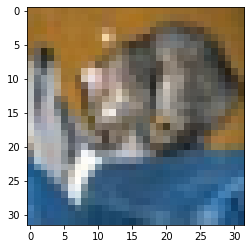

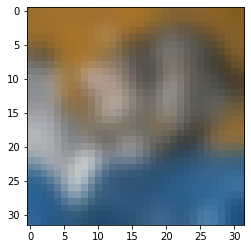

In [99]:
k = 0
image = cifar10_ds[k][0]
label = cifar10_ds[k][1]
imshow(image)

blurred = attack_blur_cv2(image.unsqueeze(0), torch.tensor(2))
# blurred = blurred.unsqueeze(0)
imshow(blurred[0])

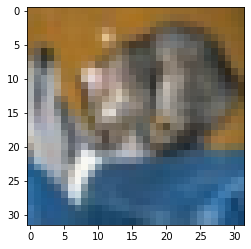

In [100]:
phi = construct_phi("blur_ray", device, sigma_blur=0.1)
blurred1 = phi(image.unsqueeze(0))

imshow(blurred1[0])

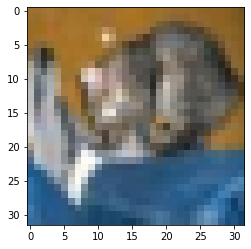

In [101]:
phi2 = construct_phi("blur_exp", device, sigma_blur=0.2)
blurred2 = phi(image.unsqueeze(0))

imshow(blurred2[0])

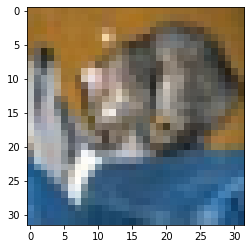

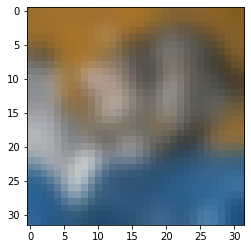

In [102]:
k = 0
image = cifar10_ds[k][0]
label = cifar10_ds[k][1]
imshow(image)

blurred = attack_blur_cv2(image.unsqueeze(0), torch.tensor(2))

imshow(blurred[0])

In [75]:
sigma_blur = 0.2
sigma_bl = sigma_blur

In [76]:
phi = construct_phi("blur_exp", device, sigma_b=sigma_b)

In [77]:
# phi(torch.randn(16, 3, 32 ,32).to(device))

In [78]:
sigmas=[None, None, None, None, sigma_blur]

I'm here


  0%|                                                                                                                                                  | 0/21 [00:00<?, ?it/s]

blur_exp
blur_exp
blur_exp
blur_exp


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 19.05it/s]


(21, 20000)
(21,)
(20000,)


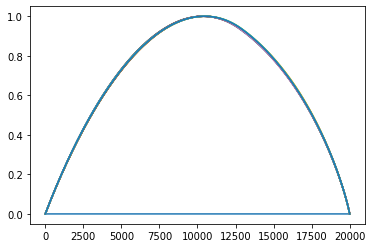

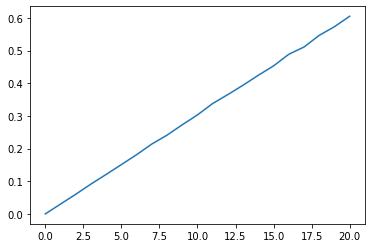

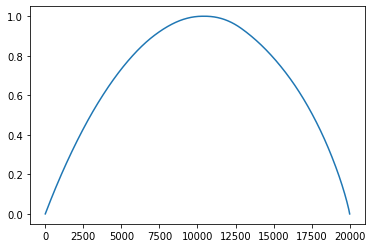

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 189.94it/s]


In [80]:
ns = 20000
b_zero = jnp.array([0.0])
x0 = jnp.array([1.1]) # Whatever
d = 1

betas1 = jnp.linspace(0, 6.0, 21)
betas_list = [betas1]
type_of_transform = 'blur_exp'

Phi = construct_phi(type_of_transform, device, sigma_blur=sigma_bl)
attack = attack_blur_cv2
res_bc = construct_bounds(ns, b_zero, x0, d, betas_list, type_of_transform, sigmas)
xi, hatg_int = res_bc

## CIFAR-10

In [81]:
model = get_architecture(arch="cifar_resnet110", dataset="cifar10", device=device)

checkpoint = torch.load('../tss_weights/cifar10/resnet110/expgaussian/lamb5/consistency/checkpoint.pth.tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [82]:
iscor_bc = Accuracy(model, loader=dataloader_cifar10, device=device) # Accuracy of non-smoothed model on original images

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 42.16it/s]

0.77


In [83]:
pas_b = pa_isOk_collector(model, loader=dataloader_cifar10, Phi=Phi, device=device,
                           n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive,
                             num_classes=10)
paCP, isOkCP = pas_b # Clopper - Pearson

print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:07<00:00,  2.66it/s]

Ordinary accuracy of Smoothed Classiifer 0.768


In [84]:
betas_attack_list = [jnp.array([1, 16])]
# np.linspace(0, 16, 3)
betas_attack = np.asarray(list(map(np.array, itertools.product(*betas_attack_list))))


In [95]:
def attack_blur_cv2(x, b):
    r = b 
    input = x[0].cpu().numpy()
    r = r.item()
    out = cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), np.sqrt(r), borderType=cv2.BORDER_REFLECT101)
    out = torch.from_numpy(out.transpose(2, 0, 1))
    return out[None, :].to(device)

In [96]:
attack = attack_blur_cv2
era = ERA_Only_ND(model, dataloader_cifar10, attack=attack, device=device, PSN=betas_attack)
print(era)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 25.23it/s]

tensor(0.7080)
tensor(0.7080)


## CIFAR-10

In [204]:
model = get_architecture(arch="cifar_resnet110", dataset="cifar10", device=device)

checkpoint = torch.load('../tss_weights/cifar10/resnet110/expgaussian/lamb5/consistency/checkpoint.pth.tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [205]:
iscor_bc = Accuracy(model, loader=dataloader_cifar10, device=device) # Accuracy of non-smoothed model on original images

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 39.93it/s]

0.764


In [207]:
pas_b = pa_isOk_collector(model, loader=dataloader_cifar10, Phi=Phi, device=device,
                           n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive,
                             num_classes=10)
paCP, isOkCP = pas_b # Clopper - Pearson

print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:55<00:00,  2.12it/s]

Ordinary accuracy of Smoothed Classiifer 0.752


In [222]:
betas_attack_list = [jnp.array([1, 16])]
# np.linspace(0, 16, 3)
betas_attack = np.asarray(list(map(np.array, itertools.product(*betas_attack_list))))


In [223]:
attack = attack_blur_cv2
era = ERA_Only_ND(model, dataloader_cifar10, attack=attack, device=device, PSN=betas_attack)
print(era)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.13it/s]

tensor(0.6940)
tensor(0.6940)


In [ ]:
era_smoothed = ERA_Only_For_Smoothed_ND(model, dataloader_cifar100, attack, Phi, device, PSN=betas_attack, n0=n0, maxn=1000, alpha=alpha, batch_size=1000, adaptive=adaptive, num_classes=100)
print(f"Type of attack {type_of_transform}. ERA of smoothed_classifier {era_smoothed}")


In [235]:
betas_attack_list = [np.linspace(1, 16, 7)]
# np.linspace(0, 16, 3)
betas_attack = np.asarray(list(map(np.array, itertools.product(*betas_attack_list))))


In [236]:
hlist = np.linspace(0.5, 1.0, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1541.13it/s]

Cert Acc blur_exp our 0.728 h_min is 0.745819397993311


In [237]:
hlist = np.linspace(0.9, 1.0, 100)
sb_tss = safe_beta_tss("blur_exp", sigma_b=sigma_b)
hmin = CertAccCheckerTSS(betas=betas_attack, hlist=hlist, xi=xi_tss, safe_beta_tss=sb_tss)
cert_acc_within_betas_bounds = ((paCP>hmin)*isOkCP).mean()
print(f'Cert Acc {type_of_transform} TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5473.21it/s]


1.0
8.047189562170502
3.5
8.047189562170502
6.0
8.047189562170502
8.5
8.047189562170502


 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5327.23it/s]


1.0
8.097951419490593
3.5
8.097951419490593
6.0
8.097951419490593
8.5
8.097951419490593


 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5607.36it/s]


1.0
8.14923392032654
3.5
8.14923392032654
6.0
8.14923392032654
8.5
8.14923392032654


 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5896.40it/s]


1.0
8.201047855504271
3.5
8.201047855504271
6.0
8.201047855504271
8.5
8.201047855504271


 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5402.71it/s]


1.0
8.253404354840749
3.5
8.253404354840749
6.0
8.253404354840749
8.5
8.253404354840749


 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5492.32it/s]


1.0
8.306314901493433
3.5
8.306314901493433
6.0
8.306314901493433
8.5
8.306314901493433


 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5634.98it/s]


1.0
8.359791347077174
3.5
8.359791347077174
6.0
8.359791347077174
8.5
8.359791347077174


 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5019.11it/s]


1.0
8.413845927598253
3.5
8.413845927598253
6.0
8.413845927598253
8.5
8.413845927598253


 43%|███████████████████████████████████████████████████████████▏                                                                              | 3/7 [00:00<00:00, 261.93it/s]


1.0
8.468491280259205
3.5
8.468491280259205
6.0
8.468491280259205
8.5
8.468491280259205


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 6618.23it/s]


1.0
8.523740461192123
3.5
8.523740461192123
6.0
8.523740461192123
8.5
8.523740461192123
11.0
8.523740461192123


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 6797.90it/s]


1.0
8.57960696418275
3.5
8.57960696418275
6.0
8.57960696418275
8.5
8.57960696418275
11.0
8.57960696418275


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 6610.41it/s]


1.0
8.636104740452417
3.5
8.636104740452417
6.0
8.636104740452417
8.5
8.636104740452417
11.0
8.636104740452417


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 4434.90it/s]


1.0
8.693248219570531
3.5
8.693248219570531
6.0
8.693248219570531
8.5
8.693248219570531
11.0
8.693248219570531


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 8313.78it/s]


1.0
8.751052331575911
3.5
8.751052331575911
6.0
8.751052331575911
8.5
8.751052331575911
11.0
8.751052331575911


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 8371.86it/s]


1.0
8.809532530391868
3.5
8.809532530391868
6.0
8.809532530391868
8.5
8.809532530391868
11.0
8.809532530391868


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 8380.23it/s]


1.0
8.868704818626883
3.5
8.868704818626883
6.0
8.868704818626883
8.5
8.868704818626883
11.0
8.868704818626883


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 9725.92it/s]


1.0
8.928585773860462
3.5
8.928585773860462
6.0
8.928585773860462
8.5
8.928585773860462
11.0
8.928585773860462


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 8152.19it/s]


1.0
8.989192576522186
3.5
8.989192576522186
6.0
8.989192576522186
8.5
8.989192576522186
11.0
8.989192576522186


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 7985.35it/s]


1.0
9.050543039481258
3.5
9.050543039481258
6.0
9.050543039481258
8.5
9.050543039481258
11.0
9.050543039481258


 57%|█████████████████████████████████████████████████████████████████████████████▋                                                          | 4/7 [00:00<00:00, 10381.94it/s]


1.0
9.112655639474045
3.5
9.112655639474045
6.0
9.112655639474045
8.5
9.112655639474045
11.0
9.112655639474045


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 9208.13it/s]


1.0
9.175549550508345
3.5
9.175549550508345
6.0
9.175549550508345
8.5
9.175549550508345
11.0
9.175549550508345


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 9828.48it/s]


1.0
9.239244679395496
3.5
9.239244679395496
6.0
9.239244679395496
8.5
9.239244679395496
11.0
9.239244679395496


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 7767.23it/s]


1.0
9.303761703575034
3.5
9.303761703575034
6.0
9.303761703575034
8.5
9.303761703575034
11.0
9.303761703575034


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 7016.82it/s]


1.0
9.3691221114118
3.5
9.3691221114118
6.0
9.3691221114118
8.5
9.3691221114118
11.0
9.3691221114118


 57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 4/7 [00:00<00:00, 181.65it/s]


1.0
9.435348245161904
3.5
9.435348245161904
6.0
9.435348245161904
8.5
9.435348245161904
11.0
9.435348245161904


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 6152.26it/s]


1.0
9.5024633468226
3.5
9.5024633468226
6.0
9.5024633468226
8.5
9.5024633468226
11.0
9.5024633468226


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 5424.25it/s]


1.0
9.570491607101493
3.5
9.570491607101493
6.0
9.570491607101493
8.5
9.570491607101493
11.0
9.570491607101493


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 4915.68it/s]


1.0
9.639458217763174
3.5
9.639458217763174
6.0
9.639458217763174
8.5
9.639458217763174
11.0
9.639458217763174


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 3920.83it/s]


1.0
9.709389427636873
3.5
9.709389427636873
6.0
9.709389427636873
8.5
9.709389427636873
11.0
9.709389427636873


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 5267.57it/s]


1.0
9.780312602596656
3.5
9.780312602596656
6.0
9.780312602596656
8.5
9.780312602596656
11.0
9.780312602596656


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 4362.25it/s]


1.0
9.852256289857154
3.5
9.852256289857154
6.0
9.852256289857154
8.5
9.852256289857154
11.0
9.852256289857154


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 1787.28it/s]


1.0
9.925250286962918
3.5
9.925250286962918
6.0
9.925250286962918
8.5
9.925250286962918
11.0
9.925250286962918


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 1995.15it/s]


1.0
9.999325715888622
3.5
9.999325715888622
6.0
9.999325715888622
8.5
9.999325715888622
11.0
9.999325715888622


 57%|█████████████████████████████████████████████████████████████████████████████▋                                                          | 4/7 [00:00<00:00, 10131.17it/s]


1.0
10.074515102711326
3.5
10.074515102711326
6.0
10.074515102711326
8.5
10.074515102711326
11.0
10.074515102711326


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 1959.27it/s]


1.0
10.150852463365267
3.5
10.150852463365267
6.0
10.150852463365267
8.5
10.150852463365267
11.0
10.150852463365267


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 2051.51it/s]


1.0
10.228373396045093
3.5
10.228373396045093
6.0
10.228373396045093
8.5
10.228373396045093
11.0
10.228373396045093


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 1542.73it/s]


1.0
10.30711518088579
3.5
10.30711518088579
6.0
10.30711518088579
8.5
10.30711518088579
11.0
10.30711518088579


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 1893.16it/s]


1.0
10.387116887617998
3.5
10.387116887617998
6.0
10.387116887617998
8.5
10.387116887617998
11.0
10.387116887617998


 57%|█████████████████████████████████████████████████████████████████████████████▋                                                          | 4/7 [00:00<00:00, 11118.10it/s]


1.0
10.4684194919769
3.5
10.4684194919769
6.0
10.4684194919769
8.5
10.4684194919769
11.0
10.4684194919769


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 1212.66it/s]

1.0
10.55106600173295
3.5
10.55106600173295
6.0
10.55106600173295
8.5
10.55106600173295
11.0
10.55106600173295



 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 2143.78it/s]

1.0
10.63510159331486
3.5
10.63510159331486
6.0
10.63510159331486
8.5
10.63510159331486
11.0
10.63510159331486



 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 5003.64it/s]

1.0
10.72057376011136
3.5
10.72057376011136
6.0
10.72057376011136
8.5
10.72057376011136
11.0
10.72057376011136



 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 2961.56it/s]


1.0
10.807532473670697
3.5
10.807532473670697
6.0
10.807532473670697
8.5
10.807532473670697
11.0
10.807532473670697


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 8586.09it/s]


1.0
10.896030359167703
3.5
10.896030359167703
6.0
10.896030359167703
8.5
10.896030359167703
11.0
10.896030359167703


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 3500.36it/s]


1.0
10.986122886681095
3.5
10.986122886681095
6.0
10.986122886681095
8.5
10.986122886681095
11.0
10.986122886681095


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
11.077868580022079
3.5
11.077868580022079
6.0
11.077868580022079
8.5
11.077868580022079
11.0
11.077868580022079
13.5
11.077868580022079


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
11.171329245082841
3.5
11.171329245082841
6.0
11.171329245082841
8.5
11.171329245082841
11.0

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 2335.36it/s]



11.171329245082841
13.5
11.171329245082841


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 1693.44it/s]


1.0
11.266570219936312
3.5
11.266570219936312
6.0
11.266570219936312
8.5
11.266570219936312
11.0
11.266570219936312
13.5
11.266570219936312


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 2036.47it/s]


1.0
11.363660649221822
3.5
11.363660649221822
6.0
11.363660649221822
8.5
11.363660649221822
11.0
11.363660649221822
13.5
11.363660649221822


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 1923.82it/s]

1.0
11.462673785702721
3.5
11.462673785702721
6.0
11.462673785702721
8.5
11.462673785702721
11.0
11.462673785702721
13.5
11.462673785702721



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 5/7 [00:00<00:00, 10743.61it/s]


1.0
11.563687322290319
3.5
11.563687322290319
6.0
11.563687322290319
8.5
11.563687322290319
11.0
11.563687322290319
13.5
11.563687322290319


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
11.666783758303998
3.5
11.666783758303998
6.0
11.666783758303998
8.5
11.666783758303998
11.0
11.666783758303998
13.5
11.666783758303998


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
11.77205080429316
3.5
11.77205080429316
6.0
11.77205080429316
8.5
11.77205080429316
11.0
11.77205080429316
13.5
11.77205080429316


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 2527.60it/s]

1.0
11.87958183039798
3.5
11.87958183039798
6.0
11.87958183039798
8.5
11.87958183039798
11.0
11.87958183039798
13.5
11.87958183039798



  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
11.989476363991857
3.5
11.989476363991857
6.0
11.989476363991857
8.5
11.989476363991857
11.0
11.989476363991857
13.5

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 2549.11it/s]



11.989476363991857


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
12.10184064325215
3.5

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 3615.78it/s]



12.10184064325215
6.0
12.10184064325215
8.5
12.10184064325215
11.0
12.10184064325215
13.5
12.10184064325215


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
12.216788234375645
3.5


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 1871.79it/s]


12.216788234375645
6.0
12.216788234375645
8.5
12.216788234375645
11.0
12.216788234375645
13.5
12.216788234375645


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
12.334440721426615
3.5
12.334440721426615
6.0
12.334440721426615
8.5

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 2786.17it/s]



12.334440721426615
11.0
12.334440721426615
13.5
12.334440721426615


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 5275.85it/s]


1.0
12.45492847932192
3.5
12.45492847932192
6.0
12.45492847932192
8.5
12.45492847932192
11.0
12.45492847932192
13.5
12.45492847932192


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 5/7 [00:00<00:00, 12185.66it/s]


1.0
12.578391542273765
3.5
12.578391542273765
6.0
12.578391542273765
8.5
12.578391542273765
11.0
12.578391542273765
13.5
12.578391542273765


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 1295.34it/s]


1.0
12.704980582195216
3.5
12.704980582195216
6.0
12.704980582195216
8.5
12.704980582195216
11.0
12.704980582195216
13.5
12.704980582195216


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 2197.81it/s]


1.0
12.834858014211518
3.5
12.834858014211518
6.0
12.834858014211518
8.5
12.834858014211518
11.0
12.834858014211518
13.5
12.834858014211518


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 1935.71it/s]


1.0
12.968199249622327
3.5
12.968199249622327
6.0
12.968199249622327
8.5
12.968199249622327
11.0
12.968199249622327
13.5
12.968199249622327


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 5/7 [00:00<00:00, 10230.01it/s]


1.0
13.1051941205629
3.5
13.1051941205629
6.0
13.1051941205629
8.5
13.1051941205629
11.0
13.1051941205629
13.5
13.1051941205629


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 8916.46it/s]

1.0
13.24604850539638
3.5
13.24604850539638
6.0
13.24604850539638
8.5
13.24604850539638
11.0
13.24604850539638
13.5
13.24604850539638



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 5225.90it/s]

1.0
13.390986189762643
3.5
13.390986189762643
6.0
13.390986189762643
8.5
13.390986189762643
11.0
13.390986189762643
13.5
13.390986189762643



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 5627.42it/s]


1.0
13.540251005511053
3.5
13.540251005511053
6.0
13.540251005511053
8.5
13.540251005511053
11.0
13.540251005511053
13.5
13.540251005511053
16.0
13.540251005511053


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 2039.54it/s]


1.0
13.69410929884482
3.5
13.69410929884482
6.0
13.69410929884482
8.5
13.69410929884482
11.0
13.69410929884482
13.5
13.69410929884482
16.0
13.69410929884482


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 7548.24it/s]


1.0
13.852852790417725
3.5
13.852852790417725
6.0
13.852852790417725
8.5
13.852852790417725
11.0
13.852852790417725
13.5
13.852852790417725
16.0
13.852852790417725


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 2368.33it/s]

1.0
14.016801904532677
3.5
14.016801904532677
6.0
14.016801904532677
8.5
14.016801904532677
11.0
14.016801904532677
13.5
14.016801904532677
16.0
14.016801904532677



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 2581.64it/s]

1.0
14.186309662911087
3.5
14.186309662911087
6.0
14.186309662911087
8.5
14.186309662911087
11.0
14.186309662911087
13.5
14.186309662911087
16.0
14.186309662911087



  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
14.361766261967439
3.5
14.361766261967439
6.0
14.361766261967439
8.5
14.361766261967439
11.0
14.361766261967439
13.5
14.361766261967439
16.0

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 3290.94it/s]



14.361766261967439


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 4062.94it/s]



14.543604482821815
3.5
14.543604482821815
6.0
14.543604482821815
8.5
14.543604482821815
11.0
14.543604482821815
13.5
14.543604482821815
16.0
14.543604482821815


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 6/7 [00:00<00:00, 13107.20it/s]


1.0
14.732306122736052
3.5
14.732306122736052
6.0
14.732306122736052
8.5
14.732306122736052
11.0
14.732306122736052
13.5
14.732306122736052
16.0
14.732306122736052


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 3217.31it/s]

1.0
14.928409688502438
3.5
14.928409688502438
6.0
14.928409688502438
8.5
14.928409688502438
11.0
14.928409688502438
13.5
14.928409688502438
16.0
14.928409688502438



  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
15.132519661103736
3.5
15.132519661103736
6.0
15.132519661103736
8.5
15.132519661103736
11.0
15.132519661103736
13.5

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 2420.72it/s]



15.132519661103736
16.0
15.132519661103736


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 6086.05it/s]



15.345317733197694
3.5
15.345317733197694
6.0
15.345317733197694
8.5
15.345317733197694
11.0
15.345317733197694
13.5
15.345317733197694
16.0
15.345317733197694


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
15.567576546051864
3.5
15.567576546051864
6.0
15.567576546051864
8.5
15.567576546051864
11.0
15.567576546051864
13.5
15.567576546051864
16.0

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 1902.47it/s]



15.567576546051864


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
15.80017662422633
3.5

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 1286.86it/s]



15.80017662422633
6.0
15.80017662422633
8.5
15.80017662422633
11.0
15.80017662422633
13.5
15.80017662422633
16.0
15.80017662422633


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 4699.12it/s]

1.0
16.044127445073492
3.5
16.044127445073492
6.0
16.044127445073492
8.5
16.044127445073492
11.0
16.044127445073492
13.5
16.044127445073492
16.0
16.044127445073492
Cert Acc blur_exp TSS 0.638 h_min is 0.9797979797979798


In [235]:
betas_attack_list = [np.linspace(1, 16, 7)]
# np.linspace(0, 16, 3)
betas_attack = np.asarray(list(map(np.array, itertools.product(*betas_attack_list))))


In [236]:
hlist = np.linspace(0.5, 1.0, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1541.13it/s]

Cert Acc blur_exp our 0.728 h_min is 0.745819397993311


In [237]:
hlist = np.linspace(0.9, 1.0, 100)
sb_tss = safe_beta_tss("blur_exp", sigma_b=sigma_b)
hmin = CertAccCheckerTSS(betas=betas_attack, hlist=hlist, xi=xi_tss, safe_beta_tss=sb_tss)
cert_acc_within_betas_bounds = ((paCP>hmin)*isOkCP).mean()
print(f'Cert Acc {type_of_transform} TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5473.21it/s]


1.0
8.047189562170502
3.5
8.047189562170502
6.0
8.047189562170502
8.5
8.047189562170502


 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5327.23it/s]


1.0
8.097951419490593
3.5
8.097951419490593
6.0
8.097951419490593
8.5
8.097951419490593


 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5607.36it/s]


1.0
8.14923392032654
3.5
8.14923392032654
6.0
8.14923392032654
8.5
8.14923392032654


 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5896.40it/s]


1.0
8.201047855504271
3.5
8.201047855504271
6.0
8.201047855504271
8.5
8.201047855504271


 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5402.71it/s]


1.0
8.253404354840749
3.5
8.253404354840749
6.0
8.253404354840749
8.5
8.253404354840749


 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5492.32it/s]


1.0
8.306314901493433
3.5
8.306314901493433
6.0
8.306314901493433
8.5
8.306314901493433


 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5634.98it/s]


1.0
8.359791347077174
3.5
8.359791347077174
6.0
8.359791347077174
8.5
8.359791347077174


 43%|██████████████████████████████████████████████████████████▋                                                                              | 3/7 [00:00<00:00, 5019.11it/s]


1.0
8.413845927598253
3.5
8.413845927598253
6.0
8.413845927598253
8.5
8.413845927598253


 43%|███████████████████████████████████████████████████████████▏                                                                              | 3/7 [00:00<00:00, 261.93it/s]


1.0
8.468491280259205
3.5
8.468491280259205
6.0
8.468491280259205
8.5
8.468491280259205


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 6618.23it/s]


1.0
8.523740461192123
3.5
8.523740461192123
6.0
8.523740461192123
8.5
8.523740461192123
11.0
8.523740461192123


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 6797.90it/s]


1.0
8.57960696418275
3.5
8.57960696418275
6.0
8.57960696418275
8.5
8.57960696418275
11.0
8.57960696418275


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 6610.41it/s]


1.0
8.636104740452417
3.5
8.636104740452417
6.0
8.636104740452417
8.5
8.636104740452417
11.0
8.636104740452417


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 4434.90it/s]


1.0
8.693248219570531
3.5
8.693248219570531
6.0
8.693248219570531
8.5
8.693248219570531
11.0
8.693248219570531


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 8313.78it/s]


1.0
8.751052331575911
3.5
8.751052331575911
6.0
8.751052331575911
8.5
8.751052331575911
11.0
8.751052331575911


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 8371.86it/s]


1.0
8.809532530391868
3.5
8.809532530391868
6.0
8.809532530391868
8.5
8.809532530391868
11.0
8.809532530391868


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 8380.23it/s]


1.0
8.868704818626883
3.5
8.868704818626883
6.0
8.868704818626883
8.5
8.868704818626883
11.0
8.868704818626883


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 9725.92it/s]


1.0
8.928585773860462
3.5
8.928585773860462
6.0
8.928585773860462
8.5
8.928585773860462
11.0
8.928585773860462


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 8152.19it/s]


1.0
8.989192576522186
3.5
8.989192576522186
6.0
8.989192576522186
8.5
8.989192576522186
11.0
8.989192576522186


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 7985.35it/s]


1.0
9.050543039481258
3.5
9.050543039481258
6.0
9.050543039481258
8.5
9.050543039481258
11.0
9.050543039481258


 57%|█████████████████████████████████████████████████████████████████████████████▋                                                          | 4/7 [00:00<00:00, 10381.94it/s]


1.0
9.112655639474045
3.5
9.112655639474045
6.0
9.112655639474045
8.5
9.112655639474045
11.0
9.112655639474045


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 9208.13it/s]


1.0
9.175549550508345
3.5
9.175549550508345
6.0
9.175549550508345
8.5
9.175549550508345
11.0
9.175549550508345


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 9828.48it/s]


1.0
9.239244679395496
3.5
9.239244679395496
6.0
9.239244679395496
8.5
9.239244679395496
11.0
9.239244679395496


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 7767.23it/s]


1.0
9.303761703575034
3.5
9.303761703575034
6.0
9.303761703575034
8.5
9.303761703575034
11.0
9.303761703575034


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 7016.82it/s]


1.0
9.3691221114118
3.5
9.3691221114118
6.0
9.3691221114118
8.5
9.3691221114118
11.0
9.3691221114118


 57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 4/7 [00:00<00:00, 181.65it/s]


1.0
9.435348245161904
3.5
9.435348245161904
6.0
9.435348245161904
8.5
9.435348245161904
11.0
9.435348245161904


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 6152.26it/s]


1.0
9.5024633468226
3.5
9.5024633468226
6.0
9.5024633468226
8.5
9.5024633468226
11.0
9.5024633468226


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 5424.25it/s]


1.0
9.570491607101493
3.5
9.570491607101493
6.0
9.570491607101493
8.5
9.570491607101493
11.0
9.570491607101493


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 4915.68it/s]


1.0
9.639458217763174
3.5
9.639458217763174
6.0
9.639458217763174
8.5
9.639458217763174
11.0
9.639458217763174


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 3920.83it/s]


1.0
9.709389427636873
3.5
9.709389427636873
6.0
9.709389427636873
8.5
9.709389427636873
11.0
9.709389427636873


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 5267.57it/s]


1.0
9.780312602596656
3.5
9.780312602596656
6.0
9.780312602596656
8.5
9.780312602596656
11.0
9.780312602596656


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 4362.25it/s]


1.0
9.852256289857154
3.5
9.852256289857154
6.0
9.852256289857154
8.5
9.852256289857154
11.0
9.852256289857154


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 1787.28it/s]


1.0
9.925250286962918
3.5
9.925250286962918
6.0
9.925250286962918
8.5
9.925250286962918
11.0
9.925250286962918


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 1995.15it/s]


1.0
9.999325715888622
3.5
9.999325715888622
6.0
9.999325715888622
8.5
9.999325715888622
11.0
9.999325715888622


 57%|█████████████████████████████████████████████████████████████████████████████▋                                                          | 4/7 [00:00<00:00, 10131.17it/s]


1.0
10.074515102711326
3.5
10.074515102711326
6.0
10.074515102711326
8.5
10.074515102711326
11.0
10.074515102711326


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 1959.27it/s]


1.0
10.150852463365267
3.5
10.150852463365267
6.0
10.150852463365267
8.5
10.150852463365267
11.0
10.150852463365267


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 2051.51it/s]


1.0
10.228373396045093
3.5
10.228373396045093
6.0
10.228373396045093
8.5
10.228373396045093
11.0
10.228373396045093


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 1542.73it/s]


1.0
10.30711518088579
3.5
10.30711518088579
6.0
10.30711518088579
8.5
10.30711518088579
11.0
10.30711518088579


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 1893.16it/s]


1.0
10.387116887617998
3.5
10.387116887617998
6.0
10.387116887617998
8.5
10.387116887617998
11.0
10.387116887617998


 57%|█████████████████████████████████████████████████████████████████████████████▋                                                          | 4/7 [00:00<00:00, 11118.10it/s]


1.0
10.4684194919769
3.5
10.4684194919769
6.0
10.4684194919769
8.5
10.4684194919769
11.0
10.4684194919769


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 1212.66it/s]

1.0
10.55106600173295
3.5
10.55106600173295
6.0
10.55106600173295
8.5
10.55106600173295
11.0
10.55106600173295



 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 2143.78it/s]

1.0
10.63510159331486
3.5
10.63510159331486
6.0
10.63510159331486
8.5
10.63510159331486
11.0
10.63510159331486



 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 5003.64it/s]

1.0
10.72057376011136
3.5
10.72057376011136
6.0
10.72057376011136
8.5
10.72057376011136
11.0
10.72057376011136



 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 2961.56it/s]


1.0
10.807532473670697
3.5
10.807532473670697
6.0
10.807532473670697
8.5
10.807532473670697
11.0
10.807532473670697


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 8586.09it/s]


1.0
10.896030359167703
3.5
10.896030359167703
6.0
10.896030359167703
8.5
10.896030359167703
11.0
10.896030359167703


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 4/7 [00:00<00:00, 3500.36it/s]


1.0
10.986122886681095
3.5
10.986122886681095
6.0
10.986122886681095
8.5
10.986122886681095
11.0
10.986122886681095


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
11.077868580022079
3.5
11.077868580022079
6.0
11.077868580022079
8.5
11.077868580022079
11.0
11.077868580022079
13.5
11.077868580022079


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
11.171329245082841
3.5
11.171329245082841
6.0
11.171329245082841
8.5
11.171329245082841
11.0

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 2335.36it/s]



11.171329245082841
13.5
11.171329245082841


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 1693.44it/s]


1.0
11.266570219936312
3.5
11.266570219936312
6.0
11.266570219936312
8.5
11.266570219936312
11.0
11.266570219936312
13.5
11.266570219936312


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 2036.47it/s]


1.0
11.363660649221822
3.5
11.363660649221822
6.0
11.363660649221822
8.5
11.363660649221822
11.0
11.363660649221822
13.5
11.363660649221822


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 1923.82it/s]

1.0
11.462673785702721
3.5
11.462673785702721
6.0
11.462673785702721
8.5
11.462673785702721
11.0
11.462673785702721
13.5
11.462673785702721



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 5/7 [00:00<00:00, 10743.61it/s]


1.0
11.563687322290319
3.5
11.563687322290319
6.0
11.563687322290319
8.5
11.563687322290319
11.0
11.563687322290319
13.5
11.563687322290319


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
11.666783758303998
3.5
11.666783758303998
6.0
11.666783758303998
8.5
11.666783758303998
11.0
11.666783758303998
13.5
11.666783758303998


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
11.77205080429316
3.5
11.77205080429316
6.0
11.77205080429316
8.5
11.77205080429316
11.0
11.77205080429316
13.5
11.77205080429316


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 2527.60it/s]

1.0
11.87958183039798
3.5
11.87958183039798
6.0
11.87958183039798
8.5
11.87958183039798
11.0
11.87958183039798
13.5
11.87958183039798



  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
11.989476363991857
3.5
11.989476363991857
6.0
11.989476363991857
8.5
11.989476363991857
11.0
11.989476363991857
13.5

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 2549.11it/s]



11.989476363991857


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
12.10184064325215
3.5

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 3615.78it/s]



12.10184064325215
6.0
12.10184064325215
8.5
12.10184064325215
11.0
12.10184064325215
13.5
12.10184064325215


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
12.216788234375645
3.5


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 1871.79it/s]


12.216788234375645
6.0
12.216788234375645
8.5
12.216788234375645
11.0
12.216788234375645
13.5
12.216788234375645


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
12.334440721426615
3.5
12.334440721426615
6.0
12.334440721426615
8.5

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 2786.17it/s]



12.334440721426615
11.0
12.334440721426615
13.5
12.334440721426615


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 5275.85it/s]


1.0
12.45492847932192
3.5
12.45492847932192
6.0
12.45492847932192
8.5
12.45492847932192
11.0
12.45492847932192
13.5
12.45492847932192


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 5/7 [00:00<00:00, 12185.66it/s]


1.0
12.578391542273765
3.5
12.578391542273765
6.0
12.578391542273765
8.5
12.578391542273765
11.0
12.578391542273765
13.5
12.578391542273765


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 1295.34it/s]


1.0
12.704980582195216
3.5
12.704980582195216
6.0
12.704980582195216
8.5
12.704980582195216
11.0
12.704980582195216
13.5
12.704980582195216


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 2197.81it/s]


1.0
12.834858014211518
3.5
12.834858014211518
6.0
12.834858014211518
8.5
12.834858014211518
11.0
12.834858014211518
13.5
12.834858014211518


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 1935.71it/s]


1.0
12.968199249622327
3.5
12.968199249622327
6.0
12.968199249622327
8.5
12.968199249622327
11.0
12.968199249622327
13.5
12.968199249622327


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 5/7 [00:00<00:00, 10230.01it/s]


1.0
13.1051941205629
3.5
13.1051941205629
6.0
13.1051941205629
8.5
13.1051941205629
11.0
13.1051941205629
13.5
13.1051941205629


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 8916.46it/s]

1.0
13.24604850539638
3.5
13.24604850539638
6.0
13.24604850539638
8.5
13.24604850539638
11.0
13.24604850539638
13.5
13.24604850539638



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 5/7 [00:00<00:00, 5225.90it/s]

1.0
13.390986189762643
3.5
13.390986189762643
6.0
13.390986189762643
8.5
13.390986189762643
11.0
13.390986189762643
13.5
13.390986189762643



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 5627.42it/s]


1.0
13.540251005511053
3.5
13.540251005511053
6.0
13.540251005511053
8.5
13.540251005511053
11.0
13.540251005511053
13.5
13.540251005511053
16.0
13.540251005511053


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 2039.54it/s]


1.0
13.69410929884482
3.5
13.69410929884482
6.0
13.69410929884482
8.5
13.69410929884482
11.0
13.69410929884482
13.5
13.69410929884482
16.0
13.69410929884482


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 7548.24it/s]


1.0
13.852852790417725
3.5
13.852852790417725
6.0
13.852852790417725
8.5
13.852852790417725
11.0
13.852852790417725
13.5
13.852852790417725
16.0
13.852852790417725


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 2368.33it/s]

1.0
14.016801904532677
3.5
14.016801904532677
6.0
14.016801904532677
8.5
14.016801904532677
11.0
14.016801904532677
13.5
14.016801904532677
16.0
14.016801904532677



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 2581.64it/s]

1.0
14.186309662911087
3.5
14.186309662911087
6.0
14.186309662911087
8.5
14.186309662911087
11.0
14.186309662911087
13.5
14.186309662911087
16.0
14.186309662911087



  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
14.361766261967439
3.5
14.361766261967439
6.0
14.361766261967439
8.5
14.361766261967439
11.0
14.361766261967439
13.5
14.361766261967439
16.0

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 3290.94it/s]



14.361766261967439


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 4062.94it/s]



14.543604482821815
3.5
14.543604482821815
6.0
14.543604482821815
8.5
14.543604482821815
11.0
14.543604482821815
13.5
14.543604482821815
16.0
14.543604482821815


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 6/7 [00:00<00:00, 13107.20it/s]


1.0
14.732306122736052
3.5
14.732306122736052
6.0
14.732306122736052
8.5
14.732306122736052
11.0
14.732306122736052
13.5
14.732306122736052
16.0
14.732306122736052


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 3217.31it/s]

1.0
14.928409688502438
3.5
14.928409688502438
6.0
14.928409688502438
8.5
14.928409688502438
11.0
14.928409688502438
13.5
14.928409688502438
16.0
14.928409688502438



  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
15.132519661103736
3.5
15.132519661103736
6.0
15.132519661103736
8.5
15.132519661103736
11.0
15.132519661103736
13.5

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 2420.72it/s]



15.132519661103736
16.0
15.132519661103736


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 6086.05it/s]



15.345317733197694
3.5
15.345317733197694
6.0
15.345317733197694
8.5
15.345317733197694
11.0
15.345317733197694
13.5
15.345317733197694
16.0
15.345317733197694


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
15.567576546051864
3.5
15.567576546051864
6.0
15.567576546051864
8.5
15.567576546051864
11.0
15.567576546051864
13.5
15.567576546051864
16.0

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 1902.47it/s]



15.567576546051864


  0%|                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

1.0
15.80017662422633
3.5

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6/7 [00:00<00:00, 1286.86it/s]



15.80017662422633
6.0
15.80017662422633
8.5
15.80017662422633
11.0
15.80017662422633
13.5
15.80017662422633
16.0
15.80017662422633


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 4699.12it/s]

1.0
16.044127445073492
3.5
16.044127445073492
6.0
16.044127445073492
8.5
16.044127445073492
11.0
16.044127445073492
13.5
16.044127445073492
16.0
16.044127445073492
Cert Acc blur_exp TSS 0.638 h_min is 0.9797979797979798


## CIFAR-100

In [238]:
model = get_architecture(arch="cifar100_resnet110", dataset="cifar100", device=device)

checkpoint = torch.load('../new_results/cifar100_resnet110_cifar100_blur_exp_cifar100_blur_exp_checkpoint.pth.tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [239]:
iscor_bc = Accuracy(model, loader=dataloader_cifar100, device=device) # Accuracy of non-smoothed model on original images

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 38.61it/s]

0.434


In [241]:
pas_b = pa_isOk_collector(model, loader=dataloader_cifar100, Phi=Phi, device=device,
                           n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive,
                             num_classes=100)
paCP, isOkCP = pas_b # Clopper - Pearson

print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:05<00:00,  2.03it/s]

Ordinary accuracy of Smoothed Classiifer 0.406


In [23]:
betas_attack_list = [jnp.array([1, 4, 8, 12, 16])]
# np.linspace(0, 16, 3)
betas_attack = np.asarray(list(map(np.array, itertools.product(*betas_attack_list))))


In [245]:
attack = attack_blur_cv2
era = ERA_Only_ND(model, dataloader_cifar100, attack=attack, device=device, PSN=betas_attack)
print(era)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.53it/s]

tensor(0.1620)
tensor(0.1620)


In [253]:
# betas_attack_era_list = [np.linspace(0.5, 2.0, 3), np.linspace(-0.4, 0.4, 3)]
# betas_attack_era = np.asarray(list(map(np.array, itertools.product(*betas_attack_era_list))))

era_smoothed = ERA_Only_For_Smoothed_ND(model, dataloader_cifar100, attack, Phi, device, PSN=betas_attack, n0=n0, maxn=1000, alpha=alpha, batch_size=1000, adaptive=adaptive, num_classes=100)
print(f"Type of attack {type_of_transform}. ERA of smoothed_classifier {era_smoothed}")
# # # # tensor(0.6300)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:24<00:00,  1.89it/s]

tensor(0.1560)
Type of attack blur_exp. ERA of smoothed_classifier 0.15600000321865082


In [254]:
betas_attack_list = [np.linspace(1, 16, 7)]
# np.linspace(0, 16, 3)
betas_attack = np.asarray(list(map(np.array, itertools.product(*betas_attack_list))))


In [255]:
hlist = np.linspace(0.5, 1.0, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1390.82it/s]

Cert Acc blur_exp our 0.298 h_min is 0.7240802675585284


In [256]:
hlist = np.linspace(0.9, 1.0, 100)
sb_tss = safe_beta_tss("blur_exp", sigma_b=sigma_b)
hmin = CertAccCheckerTSS(betas=betas_attack, hlist=hlist, xi=xi_tss, safe_beta_tss=sb_tss)
cert_acc_within_betas_bounds = ((paCP>hmin)*isOkCP).mean()
print(f'Cert Acc {type_of_transform} TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 25731.93it/s]

Cert Acc blur_exp TSS 0.094 h_min is 0.9797979797979798


## Imagenet

In [19]:
model = get_architecture(arch="resnet50", dataset="imagenet", device=device)

checkpoint = torch.load('../tss_weights/imagenet/resnet50/expgaussian/lamb_10/consistency/checkpoint.pth.tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [20]:
iscor_bc = Accuracy(model, loader=dataloader100, device=device) # Accuracy of non-smoothed model on original images

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 64.29it/s]

0.584


In [21]:
pas_b = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device,
                           n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive,
                             num_classes=1000)
paCP, isOkCP = pas_b # Clopper - Pearson

print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [23:21<00:00,  2.80s/it]

Ordinary accuracy of Smoothed Classiifer 0.582


In [24]:
hlist = np.linspace(0.5, 1.0, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1379.52it/s]

Cert Acc blur_exp our 0.562 h_min is 0.7558528428093645


In [25]:
hlist = np.linspace(0.9, 1.0, 100)
sb_tss = safe_beta_tss("blur_exp", sigma_b=sigma_b)
hmin = CertAccCheckerTSS(betas=betas_attack, hlist=hlist, xi=xi_tss, safe_beta_tss=sb_tss)
cert_acc_within_betas_bounds = ((paCP>hmin)*isOkCP).mean()
print(f'Cert Acc {type_of_transform} TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19747.19it/s]

Cert Acc blur_exp TSS 0.526 h_min is 0.9797979797979798


# Translation

In [20]:
sigma_tr = 15

In [21]:
phi = construct_phi("tr", device, sigma_b=sigma_b)

In [201]:
# phi(torch.randn(16, 3, 32 ,32).to(device))

In [22]:
sigmas=[None, None, sigma_tr, None, None]

I'm here


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:05<00:00, 75.66it/s]


(441, 20000)
(441,)
(20000,)


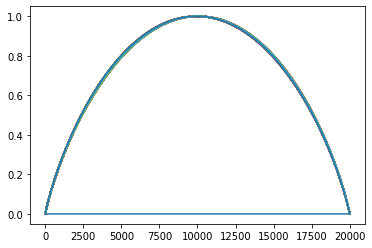

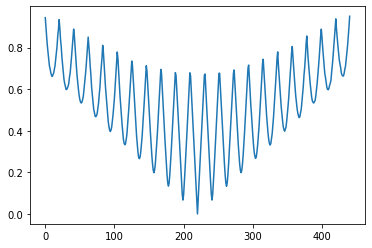

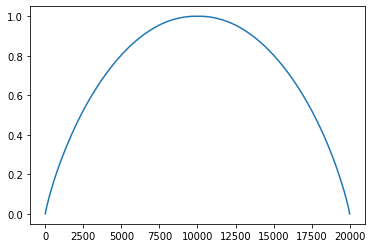

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:02<00:00, 202.31it/s]


In [23]:
ns = 20000
b_zero = jnp.array([0.0, 0.0])
x0 = jnp.array([1.1, 12]) # Whatever
d = 2

betas1 = jnp.linspace(-25, 25, 21)
betas2 = jnp.linspace(-25, 25, 21)
betas_list = [betas1, betas2]
type_of_transform = 'tr'

Phi = construct_phi(type_of_transform, device, sigma_tr=sigma_tr)
attack = attack_blur_cv2
res_bc = construct_bounds(ns, b_zero, x0, d, betas_list, type_of_transform, sigmas)
xi, hatg_int = res_bc

In [39]:
betas_attack_list = [jnp.linspace(-np.sqrt(20), np.sqrt(20), 11), jnp.linspace(-np.sqrt(20), np.sqrt(20), 11)]
betas_attack = np.asarray(list(map(np.array, itertools.product(*betas_attack_list))))

## CIFAR-10

In [24]:
model = get_architecture(arch="cifar_resnet110", dataset="cifar10", device=device)

checkpoint = torch.load('../tss_weights/cifar10/resnet110/translation/noise_15.0/consistency/checkpoint.pth.tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [25]:
iscor_bc = Accuracy(model, loader=dataloader_cifar10, device=device) # Accuracy of non-smoothed model on original images

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 40.85it/s]

0.846


In [26]:
pas_b = pa_isOk_collector(model, loader=dataloader_cifar10, Phi=Phi, device=device,
                           n0=n0, maxn=m, alpha=alpha, batch_size=256, adaptive=adaptive,
                             num_classes=10)
paCP, isOkCP = pas_b # Clopper - Pearson

print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:07<00:00,  3.91it/s]

Ordinary accuracy of Smoothed Classiifer 0.842


In [29]:
betas_era_list = [jnp.linspace(-20, 20, 2), jnp.linspace(-20, 20, 2)]
betas_era = np.asarray(list(map(np.array, itertools.product(*betas_attack_list))))

In [49]:
# attack = attack_tr_torch
# era = ERA_Only_ND(model, dataloader_cifar10, attack=attack, device=device, PSN=betas_era)
# print(era)

In [ ]:
# era_smoothed = ERA_Only_For_Smoothed_ND(model, dataloader_cifar100, attack, Phi, device, PSN=betas_era, n0=n0, maxn=1000, alpha=alpha, batch_size=1000, adaptive=adaptive, num_classes=100)
# print(f"Type of attack {type_of_transform}. ERA of smoothed_classifier {era_smoothed}")


In [33]:
hlist = np.linspace(0.5, 1.0, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:00<00:00, 2336.17it/s]

Cert Acc tr our 0.664 h_min is 0.5886287625418061


In [40]:
hlist = np.linspace(0.5, 1.0, 300)
sb_tss = safe_beta_tss("tr", sigma_tr=sigma_tr)
hmin = CertAccCheckerTSS(betas=betas_attack, hlist=hlist, xi=xi_tss, safe_beta_tss=sb_tss)
cert_acc_within_betas_bounds = ((paCP>hmin)*isOkCP).mean()
print(f'Cert Acc {type_of_transform} TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 1259.99it/s]

Cert Acc tr TSS 0.556 h_min is 0.6638795986622074


## CIFAR-100

In [43]:
model = get_architecture(arch="cifar100_resnet110", dataset="cifar100", device=device)

checkpoint = torch.load('../new_results/trcifar100_resnet110_cifar100_tr_cifar100_trans_checkpoint.pth.tar', map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [44]:
iscor_bc = Accuracy(model, loader=dataloader_cifar100, device=device) # Accuracy of non-smoothed model on original images

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 40.95it/s]

0.424


In [45]:
pas_b = pa_isOk_collector(model, loader=dataloader_cifar100, Phi=Phi, device=device,
                           n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive,
                             num_classes=100)
paCP, isOkCP = pas_b # Clopper - Pearson

print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:09<00:00,  3.87it/s]

Ordinary accuracy of Smoothed Classiifer 0.426


In [56]:
pas_b = pa_isOk_collector(model, loader=dataloader_cifar100, Phi=Phi, device=device,
                           n0=2048, maxn=10_240, alpha=alpha, batch_size=2048, adaptive=adaptive,
                             num_classes=100)
paCP, isOkCP = pas_b # Clopper - Pearson

print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [10:50<00:00,  1.30s/it]

Ordinary accuracy of Smoothed Classiifer 0.43


In [47]:
# era = ERA_Only_ND(model, dataloader_cifar100, attack=attack, device=device, PSN=betas_era)
# print(era)

In [48]:
# era_smoothed = ERA_Only_For_Smoothed_ND(model, dataloader_cifar100, attack, Phi, device, PSN=betas_era, n0=n0, maxn=1000, alpha=alpha, batch_size=1000, adaptive=adaptive, num_classes=100)
# print(f"Type of attack {type_of_transform}. ERA of smoothed_classifier {era_smoothed}")

In [57]:
hlist = np.linspace(0.5, 1.0, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 1402.53it/s]

Cert Acc tr our 0.284 h_min is 0.5886287625418061


In [58]:
hmin = CertAccCheckerTSS(betas=betas_attack, hlist=hlist, xi=xi_tss, safe_beta_tss=sb_tss)
cert_acc_within_betas_bounds = ((paCP>hmin)*isOkCP).mean()
print(f'Cert Acc {type_of_transform} TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 1160.74it/s]

Cert Acc tr TSS 0.228 h_min is 0.6638795986622074


In [60]:
for n in [1, 2, 3, 4, 5 ,6]:
    print(0.001 ** (1/10**n))

0.5011872336272722
0.933254300796991
0.9931160484209338
0.9993094630025899
0.9999309248330094
0.9999930922685795


# CT

In [17]:
sigma_c = 0.4
sigma_tr = 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3468/3468 [02:41<00:00, 21.54it/s]


(3468, 20000)
(3468,)
(20000,)


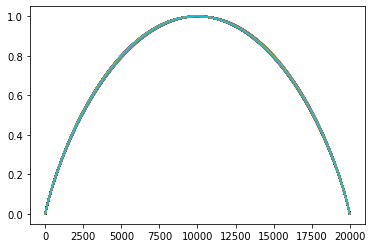

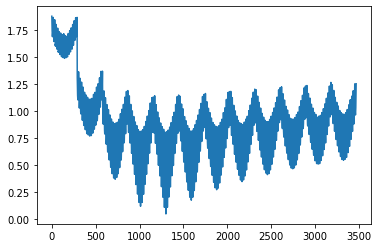

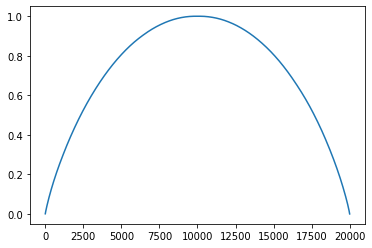

In [20]:
ns = 20000
x0 = jnp.array([1.1,0.3, -10]) # WHATEVER 
d = 3
b_zero = jnp.array([1.0, 0.0, 0.0])

betas1 = jnp.linspace(0.4, 2.2, 12) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-60, 60, 17)
betas3 = jnp.linspace(-60, 60, 17)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3)))) 

type_of_transform = 'ct'
bounds, p, g = compute_normed_bounds(compute_bound, x0, construct_gamma(), b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)

for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()




In [21]:
betas_list = [betas1, betas2, betas3]
shape = [b.shape[0] for b in betas_list]
z = csaps(betas_list, g.reshape(shape))

hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)

hat_g = jnp.asarray(hg)

hatg_int = csaps(betas_list, hat_g.reshape(shape)) #

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3468/3468 [00:51<00:00, 67.56it/s]


In [22]:
xs = np.linspace(0.5,1-1e-4,100)
r_our = lambda h: -xi(1-h)+xi(0.5)
# r_tss_bc= lambda h: 1/2*(xi(h) - xi(1-h))

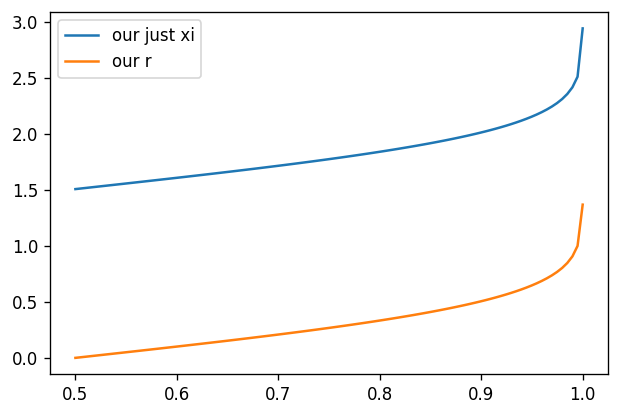

In [23]:
plt.figure(dpi=120)
plt.plot(xs, xi(xs), label='our just xi')
plt.plot(xs, r_our(xs), label='our r')
# plt.plot(xs, r_tss_bc(xs), '--', label='tss')
# plt.yscale('log')
plt.legend()
plt.show()


In [12]:
torch.cuda.is_available()

True

**In case of problems, add `
map_location=device`**)

In [16]:
# checkpoint = torch.load('ReportResults/ContrasttTrans_08_40_checkpoint.pth.tar')
checkpoint = torch.load('../checkpoints/trans_blur_bright_contrast/TransBrightBlurContrast_40_04_10_04_checkpoint.pth.tar', map_location=device)
model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
normalize_layer = get_normalize_layer('imagenet', device).to(device)#.cuda()
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [24]:
# test_dataset = get_dataset('imagenet', 'test')
# pin_memory = False  # ('imagenet' == "imagenet")
# bs = 64


# testloader1 = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=6, pin_memory=False)


# ourdataset100 = make_our_dataset(testloader1, 100)

# dataloader100  = DataLoader(ourdataset100, shuffle=False, batch_size=1,
#                          num_workers=6, pin_memory=False)

In [20]:
iscor = Accuracy(model, loader=dataloader100, device=device) # Accuracy of non-smoothed model on original images

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 64.90it/s]

0.704


In [ ]:
Phi = construct_phi(type_of_transform, device, sigma_c=sigma_c, sigma_tr=sigma_tr)
attack = attack_ct_torch

In [28]:
pas_ct = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device, n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive)
paCP, isOkCP = pas_ct # Clopper - Pearson

100%|██████████| 500/500 [09:24<00:00,  1.13s/it]


In [29]:
print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

Ordinary accuracy of Smoothed Classiifer 0.298


(array([ 43.,  68., 127., 132.,  50.,  15.,  18.,  18.,  14.,  15.]),
 array([0.07379453, 0.16173982, 0.2496851 , 0.33763039, 0.42557567,
        0.51352096, 0.60146624, 0.68941153, 0.77735681, 0.8653021 ,
        0.95324738]),
 <BarContainer object of 10 artists>)

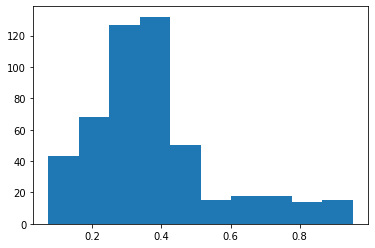

In [30]:
plt.hist(paCP)

In [42]:
betas1a = jnp.linspace(0.8, 1.2, 10) ## set a bit larger range than you want to certify
betas2a = jnp.linspace(-25, 25, 11)
betas3a = jnp.linspace(-25, 25, 11)
betas_attack = jnp.asarray(list(map(jnp.array, itertools.product(betas1a, betas2a, betas3a))))



In [43]:
# hlist = [0.2, 0.5, 0.53,0.55, 0.6, 0.62, 0.65, 0.66, 0.67, 0.68, 0.7, 0.8,0.83, 0.85, 0.87 ,0.9, 0.93]
hlist = np.linspace(0.5, 1, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|██████████| 1210/1210 [00:01<00:00, 792.79it/s]

Cert Acc ct our 0.024 h_min is 0.7558528428093645


In [45]:
((paCP>hmin)).mean()

0.07

In [52]:
def make_accuracy_df_3D_to_2D_trans(betas, hs, correct, hatg_int, safe_beta = safe_beta,
                                    ifTSS = False, ifOURnew=False, extent = [0, 80.0, 0.5, 2.0], name = 'Certified accuracy for composition of Contrast and Translation'):
    beta_d = {'c': list(), 't1':list(), 't2':list()}
    accuracy = np.zeros(len(betas))

    for i, beta in enumerate(tqdm(betas)):
        beta_d['c'].append(beta[0])
        beta_d['t1'].append(beta[1])
        beta_d['t2'].append(beta[2])
        
        if ifOURnew:
            for h1, isOk in zip(hs, correct):
                accuracy[i] += (safe_beta(xi, h1, hatg_int, (beta[0],beta[1], beta[1])).item() * isOk) #, beta[2]
        elif ifTSS:
            for h1, isOk in zip(hs, correct):
                accuracy[i] += (safe_beta(xi_tss, h1, [*beta]).item() * isOk) #, beta[2]

        accuracy[i] /= len(correct)

    
    tn = []
    cs = []
    accs = []
    all_params = []

    for i, (c, t1, t2) in enumerate(zip(beta_d['c'], beta_d['t1'], beta_d['t2'])):
        t_norm = jnp.linalg.norm([t1, t2]).item()
        c_ = c.item()
        tn.append(t_norm)
        cs.append(c_)
        accs.append(accuracy[i])


    tns = []
    css = []
    acc_d = {}
    for x,y,z in zip(tn, cs, accs):
        if not x in tns:
            tns.append(x)
        if not y in css:
            css.append(y)
        acc_d[x,y] = z
        
    accdf = pd.DataFrame(data = jnp.array(list(acc_d.values())).reshape(len(css), len(tns)), index=css, columns=tns)
    accdf = accdf.reindex(sorted(accdf.columns), axis=1)
    clps = []
    for x in accdf.values:
        z = (np.asarray(list(map(np.array, x))))
        clps.append(z)

    plt.figure(figsize=(12,7))
    plt.imshow(clps, extent=extent, aspect='auto')
    #plt.set_ylabel([1., 11.])
    plt.title(name, fontsize=15)
    plt.xlabel(r'||v|| of translation parameter v', fontsize=15)
    plt.ylabel(r'$b$ contrast transform', fontsize=15)
    plt.colorbar();
    if ifOURnew:
        plt.savefig(dirname+'ct_our.png')
    else:
        plt.savefig(dirname+'ct_tss.png')
    return accdf, clps, acc_d

In [54]:
# accdf, clps, acc_d = make_accuracy_df_3D_to_2D_trans(betas, paCP, isOkCP, hatg_int, safe_beta = safe_beta, ifTSS = False, ifOURnew=True, extent = [0, 80.0, 0.5, 2.0])



# min(list(acc_d.values()))

# Contrast + Brightnest + Translation

In [17]:
sigma_tr = 10
sigma_c = 0.4
sigma_b = 0.4

In [18]:
sigmas=[sigma_b, sigma_c, sigma_tr, None, None]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14641/14641 [24:22<00:00, 10.01it/s]


(14641, 12000)
(14641,)
(12000,)


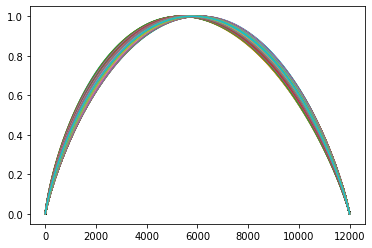

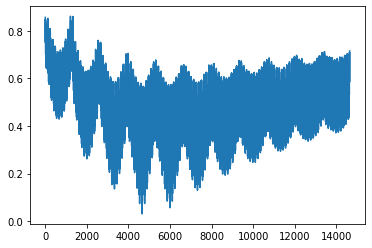

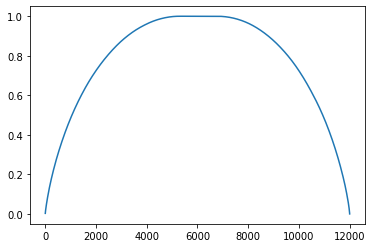

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14641/14641 [46:40<00:00,  5.23it/s]


In [19]:
ns = 12000
x0 = jnp.array([0.2 ,1.0, 3., 1])
d = 4
b_zero = jnp.array([1.0, 0.0, 0.0, 0.0])

betas1 = jnp.linspace(0.7, 1.6, 11)
betas2 = jnp.linspace(-0.3, 0.3, 11)
betas3 = jnp.linspace(-30.0, 30.0, 11).astype(int)# * 1.0 # set more steps
betas4 = jnp.linspace(-30.0, 30.0, 11).astype(int) * 1.0
betas_list = [betas1, betas2, betas3, betas4]
type_of_transform = 'cbt'

betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4)))) 

bounds, p, g = compute_normed_bounds(compute_bound, x0, construct_gamma(), b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)

for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

shape = [b.shape[0] for b in betas_list]
z = csaps(betas_list, g.reshape(shape))

hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)

hat_g = jnp.asarray(hg)

hatg_int = csaps(betas_list, hat_g.reshape(shape)) #


In [20]:
# checkpoint = torch.load('../checkpoints/trans_blur_bright_contrast/TransBrightBlurContrast_40_04_10_04_checkpoint.pth.tar', map_location=device)
checkpoint = torch.load('../tss_weights/imagenet/resnet50/universal/consistency/noise_setting_A_clean/checkpoint.pth.tar', map_location=device)
model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
normalize_layer = get_normalize_layer('imagenet', device).to(device)#.cuda()
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [21]:
Phi = construct_phi(type_of_transform, device, sigma_c=sigma_c, sigma_b=sigma_b, sigma_tr=sigma_tr)
attack = attack_cbt_torch

In [22]:
pas_cbt = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device, n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive)
paCP, isOkCP = pas_cbt # Clopper - Pearson

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:06<00:00,  1.09s/it]


In [24]:
isOkCP.mean()

0.506

In [25]:
betas1a = jnp.linspace(0.8, 1.5, 5)
betas2a = jnp.linspace(-0.2, 0.2, 5)
betas3a = jnp.linspace(-25.0, 25.0, 5).astype(int) * 1.0 # set more steps
betas4a = jnp.linspace(-25.0, 25.0, 5).astype(int) * 1.0

betas_attack = jnp.asarray(list(map(jnp.array, itertools.product(betas1a, betas2a, betas3a, betas4a)))) 

In [26]:
print('Ordinary accuracy of Smoothed Classiifer', np.mean(isOkCP))

Ordinary accuracy of Smoothed Classiifer 0.506


In [23]:
# era = ERA_Only_ND(model, dataloader100, attack = attack, device=device, PSN=betas_attack)
# era

In [27]:
betas1a = jnp.linspace(0.8, 1.2, 5)
betas2a = jnp.linspace(-0.1, 0.1, 5)
betas3a = jnp.linspace(-10.0, 10.0, 5).astype(int) * 1.0 # set more steps
betas4a = jnp.linspace(-10.0, 10.0, 5).astype(int) * 1.0

betas_attack = jnp.asarray(list(map(jnp.array, itertools.product(betas1a, betas2a, betas3a, betas4a)))) 

In [28]:
# hlist = [0.2, 0.5, 0.53,0.55, 0.6, 0.62, 0.65, 0.66, 0.67, 0.68, 0.7, 0.8,0.83, 0.85, 0.87 ,0.9, 0.93]
hlist = np.linspace(0.5, 1, 300)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:06<00:00, 100.21it/s]

Cert Acc cbt our 0.11 h_min is 0.6755852842809364


In [ ]:
2

In [54]:
cert_acc_cbt = cert_acc_within_betas_bounds

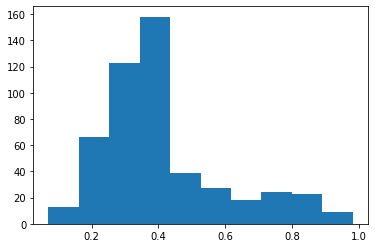

In [34]:
plt.hist(pas_cbt[0])
plt.show()

In [ ]:
pas_cbt[0].mean()

# TRANS BLUR BRIGHT CONTRAST

In [257]:
sigma_tr = 30
sigma_blur = 4
sigma_b = 0.8
sigma_c = 0.8

In [258]:
sigmas=[sigma_b, sigma_c, sigma_tr, None, sigma_blur]

In [259]:
ns = 10000
x0 = jnp.array([1.0,3.0, 3., 1, 1.1]) # WHATEVER 
d = 5
b_zero = jnp.array([0.0, 0.0, 0.0,0.0, 1.0])

betas1 = jnp.linspace(-5, 5, 5) ## set a bit larger range than you want to certify
betas2 = jnp.linspace(-5, 5, 5)
betas3 = jnp.linspace(0, 3, 6)
betas4 = jnp.linspace(-0.2, 0.2, 5)
betas5 = jnp.linspace(0.9, 1.1, 5)
betas = jnp.asarray(list(map(jnp.array, itertools.product(betas1, betas2, betas3, betas4, betas5)))) 



type_of_transform = 'tbbc_ray'
bounds, p, g = compute_normed_bounds(compute_bound, x0, construct_gamma(), b_zero, betas, key, ns, d, type_of_transform)

x, xi = pxi_to_xi(p)


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2898/3750 [04:27<01:18, 10.82it/s]


KeyboardInterrupt: 

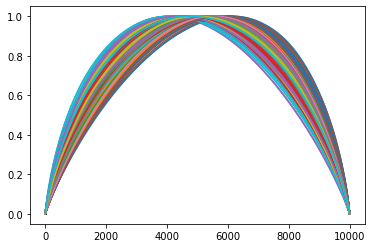

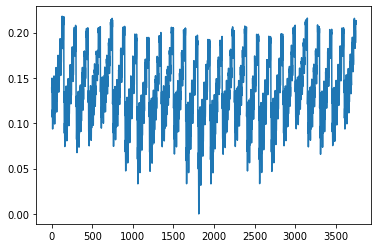

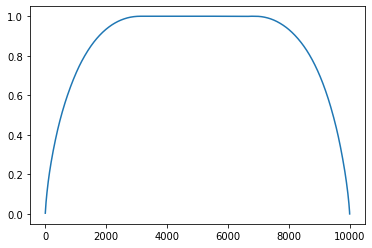

In [57]:
for b in bounds[:1000]:
    plt.plot(b)
plt.show()

plt.plot(g)
plt.show()

plt.plot(p)
plt.show()

In [ ]:
z = csaps([betas1, betas2, betas3, betas4, betas5], g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape, *betas5.shape)) # interpolate


hg = []

for beta in tqdm(betas):
    hat_g = g_to_hat_g(z, beta, b_zero)
    hg.append(hat_g)
    
hat_g = jnp.asarray(hg)

hatg_int = csaps([betas1, betas2, betas3, betas4, betas5], hat_g.reshape(*betas1.shape, *betas2.shape, *betas3.shape, *betas4.shape, *betas5.shape)) #intterpolation of Integral g(beta)

In [63]:
import cv2 
import math

class Gaussian:
    # it adopts uniform distribution
    def __init__(self, sigma):
        self.sigma = sigma
        self.sigma2 = sigma ** 2.0

    def gen_param(self):
        r = random.uniform(0.0, self.sigma2)
        return r

    def proc(self, input, r2):
        if (abs(r2) < 1e-6):
            return input
        input = input.cpu().numpy()
        out = cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), math.sqrt(r2), borderType=cv2.BORDER_REFLECT101)
        if out.ndim == 2:
            out = np.expand_dims(out, 2)
        out = torch.from_numpy(out.transpose(2, 0, 1))
        return out #.cuda()
    
    def proc_new(self, input, r2):
        if (abs(r2) < 1e-6):
            return input
#         print(input.shape)
        input = input.cpu().numpy()
#         print(input.shape)
        out = cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), math.sqrt(r2), borderType=cv2.BORDER_REFLECT101)
        if out.ndim == 2:
            out = np.expand_dims(out, 2)
        out = torch.from_numpy(out.transpose(2, 0, 1))
        
        return out #.cuda()

    def batch_proc(self, inputs):
        outs = torch.zeros_like(inputs)
        for i in range(len(inputs)):
            outs[i] = self.proc(inputs[i], self.gen_param())
        return outs
    
class ExpGaussian(Gaussian):
    # it adopts exponential distribution
    # where the sigma is actually lambda in exponential distribution Exp(1/lambda)
    def __init__(self, sigma):
        super(ExpGaussian, self).__init__(sigma)
        self.sigma = sigma

    def gen_param(self):
#         r = - self.sigma * math.log(random.uniform(0.0, 1.0))
        r = np.random.exponential(scale=self.sigma)
        r = r#.to(device)
        return r
    
class RayGaussian(Gaussian):
    # it adopts exponential distribution
    # where the sigma is actually lambda in exponential distribution Exp(1/lambda)
    def __init__(self, sigma):
        super(RayGaussian, self).__init__(sigma)
        self.sigma = sigma

    def gen_param(self):
#         r = - self.sigma * math.log(random.uniform(0.0, 1.0))
        r = np.random.rayleigh(scale=self.sigma)
        return r
    

[autoreload of cv2.load_config_py3 failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.8/importlib/__init__.py", line 159, in reload
    raise ImportError(msg.format(parent_name),
ImportError: parent 'cv2' not in sys.modules
]
[autoreload of cv2.data failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/conda/lib/p

In [64]:
# def norm_to_exp_torch(s, lam):
#     norm1 = torch.randn(s)
#     norm2 = torch.randn(s)
#     norm3 = torch.randn(s)
#     norm4 = torch.randn(s)
#     return torch.abs(norm1 * norm2 - norm3 * norm4) / lam
    

In [272]:
def attack_blur_cv2(x, b):
    r = b 
    input = x[0].cpu().numpy()
    r = r.item()
    out = cv2.GaussianBlur(input.transpose(1, 2, 0), (0, 0), np.sqrt(r), borderType=cv2.BORDER_REFLECT101)
    out = torch.from_numpy(out.transpose(2, 0, 1))
    return out[None, :].to(device)
    

def phi_blur_torch_batch_and_noise(x, sigma_blur = sigma_blur):
    
    if not exp_smoothing:
        norm1 = torch.randn(len(x))
        norm2 = torch.randn(len(x))
        ray = torch.sqrt(norm1**2 + norm2**2)
        exp = ray ** 2
        blur_radii = sigma_blur * exp
    else:
        blur_radii = norm_to_exp_torch(len(x), sigma_blur)

#     blur_radii = sigma_blur * norm_to_exp_torch(torch.randn(len(x)))
    for i in range(len(x)):
        x[i] = attack_blur_cv2(x[i][None, :], blur_radii[i])
    return x.to(device)

In [273]:
def attack_tbbc_torch(x, b):  # tr bl br c

    x = x.to(device)
    translation = torch.tensor([[b[0].item(), b[1].item()]]).to(torch.float).to(device) 
    x = kornia.geometry.transform.translate(x, translation, padding_mode='reflection')
    x = attack_blur_cv2(x, b = b[2])
    x = x + torch.tensor(b[3].item())
    x = torch.tensor(b[4].item())*x
    return x



def phi_tbbc_torch_batch_and_noise(x): 
    x = x.to(device)
    
    c1 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    c2 = (torch.randn(len(x)) * sigma_tr).long()*1.0
    t = torch.tensor([1,0])
    T = t.expand(len(x), *t.shape).clone()
    T[:, 0] = c1.squeeze().clone()
    T[:, 1] = c2.squeeze().clone()
    x = kornia.geometry.transform.translate(x.to(device), T.float().to(device), padding_mode='reflection')
    
    x = phi_blur_torch_batch_and_noise(x)
    if exp_smoothing:
        blur = ExpGaussian(sigma_blur)
    else:
        blur = RayGaussian(sigma_blur)
    x = blur.batch_proc(x)
    
    b = (torch.randn(len(x)) * sigma_b)[:, None, None, None].to(device)
    x = x + b
    
    c = torch.exp(torch.randn(len(x)) * sigma_c)[:, None, None, None].to(device)
    x = c * x
    
    return x

In [266]:
!ls ../tss_weights/imagnet/resnet50/universal/consistency

ls: cannot access '../tss_weights/imagnet/resnet50/universal/consistency': No such file or directory


In [265]:
pwd

'/workspace/mnt/local/data/dkorzh/general_lipschitz/notebooks'

In [267]:
# checkpoint = torch.load('../checkpoints/trans_blur_bright_contrast/TransBrightBlurContrast_40_04_10_04_checkpoint.pth.tar', map_location=device)

checkpoint = torch.load('../tss_weights/imagenet/resnet50/universal/consistency/noise_setting_A_clean/checkpoint.pth.tar', map_location=device)
model = torchvision.models.resnet50(pretrained=False).to(device)#.cuda()
normalize_layer = get_normalize_layer('imagenet', device).to(device)#.cuda()
model = torch.nn.Sequential(normalize_layer, model)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to(device)

In [268]:
exp_smoothing = False

In [269]:
betas1a = jnp.linspace(-3, 3, 5) ## set a bit larger range than you want to certify
betas2a = jnp.linspace(-3, 3, 5)
betas3a = jnp.linspace(1, 3, 3)
betas4a = jnp.linspace(-0.1, 0.1, 7)
betas5a = jnp.linspace(0.95, 1.05, 5)
betas_attack = jnp.asarray(list(map(jnp.array, itertools.product(betas1a, betas2a, betas3a, betas4a, betas5a)))) 

In [270]:
Accuracy(model, dataloader100, device)
# 0.65

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 61.85it/s]

0.644


array([[False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

In [271]:
Phi = phi_tbbc_torch_batch_and_noise
attack = attack_tbbc_torch

NameError: name 'phi_tbbc_torch_batch_and_noise' is not defined

In [72]:
pas_tbbc = pa_isOk_collector(model, loader=dataloader100, Phi=Phi, device=device, n0=n0, maxn=maxn, alpha=alpha, batch_size=256, adaptive=adaptive)
paCP, isOkCP = pas_tbbc # Clopper - Pearson

100%|██████████| 500/500 [3:12:39<00:00, 23.12s/it]  


In [73]:
hlist = np.linspace(0.5, 1, 101)
hmin = CertAccChecker(safe_beta, betas=betas_attack, hlist=hlist, xi=xi, hatg_int=hatg_int)
cert_acc_within_betas_bounds = ((paCP>hmin).astype('int')*isOkCP).mean()
print(f'Cert Acc {type_of_transform} our', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|██████████| 2625/2625 [00:14<00:00, 179.60it/s]

Cert Acc tbbc_ray our 0.202 h_min is 0.6


In [90]:
# for exponential smoothing TSS has the result

$\tilde{p}_A>1-\exp \left(-\lambda_B \alpha_B\right)\left(1-\Phi\left(\sqrt{\frac{\alpha_k^2}{\sigma_k^2}+\frac{\alpha_b^2}{e^{-2 \alpha_k} \sigma_b^2}+\frac{\alpha_{T x}^2+\alpha_{T y}^2}{\sigma_T^2}}\right)\right) .$

In [74]:
# sigma_b = 0.3
# sigma_c = 0.3
# sigma_tr = 10
# sigma_blur = 3
# safe_beta_tss(xi, h, [*beta]).item():
def safe_beta_tss_tbbc(xi, h, bs):
    Tx = bs[0]
    Ty = bs[1]
    B = bs[2]
    b = bs[3]
    k = np.log(bs[4])
    q = k**2/sigma_c**2 + b**2/(np.exp(-2*k) * sigma_b**2) + (Tx**2+Ty**2)/(sigma_tr**2)
    q = scipy.stats.norm.cdf(q)
    q = 1-q
    sb = 1  # sigma_blur
    q1 = np.exp(-B/sigma_blur)
    
    return h>(1-q1*q)
    
    

In [75]:
xi_tss = scipy.stats.norm.ppf

In [76]:
hlist = np.linspace(0.5, 1, 101)
hmin = CertAccCheckerTSS(betas=betas_attack, hlist=hlist, xi=xi_tss, safe_beta_tss=safe_beta_tss_tbbc)
cert_acc_within_betas_bounds = ((paCP>hmin)*isOkCP).mean()
print('Cert Acc CB TSS', cert_acc_within_betas_bounds, 'h_min is', hmin)

100%|██████████| 2625/2625 [00:03<00:00, 713.20it/s]

Cert Acc CB TSS 0.142 h_min is 0.775


In [ ]:
2-2